In [6]:
from collections import Counter, OrderedDict, defaultdict
import datetime as dt
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from scipy import stats
from scipy.stats import kstest
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

import json
import os
import pickle
from tqdm import tqdm
from datetime import date

import warnings
warnings.filterwarnings('ignore')

# Table of Contents
* [RQ1: Relation between Box Office sales and number of quotes of a movie](#chapter1) 
    * [1.1. Linear regression between total number of quotes on a movie and domestic box office revenue](#chapter11)
    * [1.2. Observational study with propensity score matching](#chapter12)
* [RQ2: Sentiment analysis in quotes about movies over time](#chapter2)
* [RQ3: An Investigation into Time Series Box Office and Quotes in a Few Movies](#chapter3)
    * [3.1. Initial analysis and Kolmogorov-Smirnov test](#chapter31)
    * [3.2. Checking correlation and Granger causality](#chapter32)
* [RQ4: Searching for a bias in the data](#chapter4)
* [RQ5: The effect of COVID on media coverage of movies](#chapter5)
    * [5.1. Calculate mean number of quotes on movies between 2015-2019 on a daily basis, calculate confidence intervals (bootstrapping), compare with 2020 data](#chapter51)
    * [5.2. Use regression for comparison of the mean number of quotes across movies in covid and non-covid period, use t-test for comparison of means](#chapter52)

# RQ1 Relation between Box Office sales and number of quotes of a movie <a class="anchor" id="chapter1"></a>

## Is there a tendency between number of sold tickets and the 'hype' about a movie as it appears in the news paper media?

For this question, we will only consider the total number of quotes on a movie found in the Quotebank dataset. We start with the IMDb movie dataset and filter out the top 50 movies in terms of *usa_gross_income*. Then we filter the Quotebank dataset on the titles of these movies and count the occurences.

In [7]:
df = pd.read_csv('./exploratory/data/IMDb/IMDb movies.csv')

We do a preprocessing on the imdb dataset. Transforming years, incomes and budgest to integers, publisd dates to datetime object.

In [8]:
def clean_imdb(df):
    imdb = df.rename(columns = {'worlwide_gross_income':'worldwide_gross_income'})
    imdb = imdb.drop(imdb.index[83917])
    imdb['year'] = imdb['year'].astype(int)
    imdb = imdb[imdb['year']>2014]
    imdb = imdb.dropna()
    imdb['budget'] = imdb['budget'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(int)
    imdb['worldwide_gross_income'] = imdb['worldwide_gross_income'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(int)
    imdb['usa_gross_income'] = imdb['usa_gross_income'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(int)
    imdb['date_published'] = pd.to_datetime(imdb['date_published'])
    return imdb

imdb = clean_imdb(df)

OverflowError: Python int too large to convert to C long

Tehre are movie titles which might be really frequent in the Quotebank dataset, the corresponding quote might come from different context, making our analysis biased so we filter them out, the result is a dictionary with the relevant movie titles, we run them through our Quotebank filter pipeline. 

In [ ]:
ignore = {2015: ['Home',  'Spy', 'Sisters',  'Joy'],
2016: ['Sing', 'Trolls',  'Split'],
2017: ['It',   'Coco'],
2018: ['Halloween'],
2019: ['Us', 'Glass', 'Yesterday',  'Midway'],
2020: ['Tesla',  'Emma.', 'Wendy']}

relevant_movies = []
titles_by_year = defaultdict(list)
for year in range(2015, 2021):
    titles_by_year[year] = list(imdb[imdb['year']==year].nlargest(50, columns='usa_gross_income')['original_title'])
    relevant_movies.append(imdb[imdb['year']==year].nlargest(50, columns='usa_gross_income')[['original_title', 'usa_gross_income', 'year']])
    for title in ignore[year]:
        titles_by_year[year].remove(title)

movies_df = pd.concat(relevant_movies)

For a movie released in year $x$, we look for quotes containing the title (or subtitle) of the movie in year $x$ and $x+1$. In this way we will have information about the hype before the publish date and see the afterlife as well. The filtering happened using in a different python script, we just load the json files containing the results.

In [ ]:
quotes_by_movies_by_year = defaultdict(list)

for i in range(2015, 2021):
    path = f'./exploratory/data/rq1/final_movie_quotes{i}.json'
    with open(path, 'r') as f:
        data = json.load(f)
    for (k, v) in data.items():
        quotes_by_movies_by_year[k].append(v)

quotes_by_movies = defaultdict(list)

for (k,v) in quotes_by_movies_by_year.items():
    quotes_by_movies[k] = sum(v)

quotes_by_movies = OrderedDict(sorted(quotes_by_movies.items(), key=lambda t: -t[1]))

In [ ]:
for i, (k,v) in enumerate(quotes_by_movies.items()):
    if i < 10:
        print(f"{k}, {v}")

We delete the top 3 element, since the quotes containing the words *Kong*, *International* and *Impossible* are likely to come from non-movie related context.

In [ ]:
del quotes_by_movies['Men in Black: International']
del quotes_by_movies['Kong: Skull Island']
del quotes_by_movies['Mission: Impossible - Fallout']

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,10)) # here we should decide a split (0-50 vs 50-100?)
ax[0].plot(quotes_by_movies.values(), marker='o')
ax[0].set_ylabel('number of quotes')
ax[0].set_xlabel('rank of movie')
ax[1].loglog(quotes_by_movies.values(), marker='o', color='red')
ax[1].set_ylabel('log number of quotes')
ax[1].set_xlabel('log rank of movie')

We sort the movies by number of quotes and visualize the distribution. It looks like a power low, but if we change to log-log axes, we can see it is clearly not a straight line.

Now we megre the information about quotes into our *movies_df* dataframe.

In [4]:
numOccurrences = pd.DataFrame()
numOccurrences['original_title'] = quotes_by_movies.keys()
numOccurrences['number_of_quotes'] = quotes_by_movies.values()
movies_df= pd.merge(movies_df,numOccurrences, how='left', on='original_title') 
movies_df

NameError: name 'quotes_by_movies' is not defined

---

## Proposed method: 
## 1.1 Linear regression between total number of quotes on a movie and domestic box office revenue <a class="anchor" id="chapter11"></a>

We run a linear regression to investigate whether more popular movies tend to have higher media coverage or not. We use statsmodels ols function to do so.

In [5]:
res = smf.ols(formula='usa_gross_income ~ number_of_quotes', data=movies_df).fit()
print(res.summary())

NameError: name 'movies_df' is not defined

We conclude that the predictor *number_of_quotes* is indeed significant, since its small p-value. So in general the more successful a movie, the more media coverage it gets. 

<AxesSubplot:title={'center':'Number of quotes vs worldwide income of selected movies per year'}, xlabel='usa_gross_income', ylabel='number_of_quotes'>

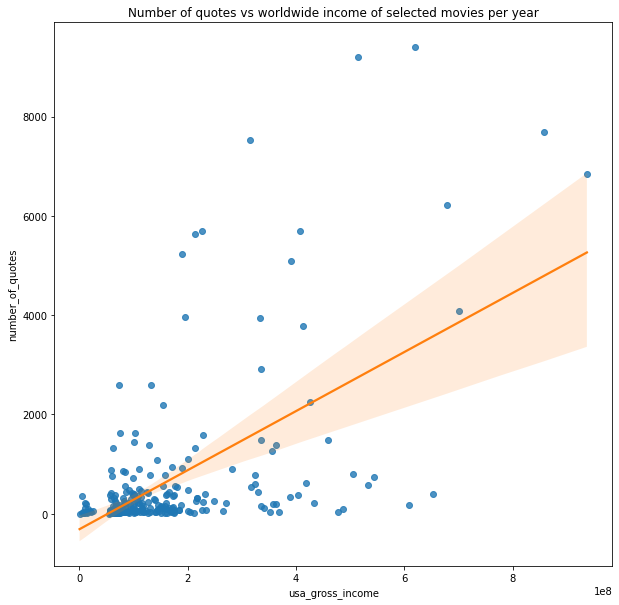

In [11]:
plt.figure(figsize = (10,10))
plt.title('Number of quotes vs worldwide income of selected movies per year')
sns.regplot(data=movies_df, x='usa_gross_income', y='number_of_quotes', line_kws = {'color': 'C1'})

---

## Proposed Method:
## 1.2. Observational study with propensity score matching <a class="anchor" id="chapter12"></a>

We calculate propensity score with logistic regression, based on movie attributes on IMDb data on few quote vs many quote movies and compare the results with box office data.

We will add the following features from the IMDb dataset: *avg_vote*, *budget*, *duration*, *metascore*, *votes*. Furthermore, we create a *genres* one hot feature as well.

In [12]:
movies_df = movies_df.merge(imdb[['original_title', 'avg_vote', 'budget','duration', 'metascore', 'votes','genre']], how='left', on='original_title')
movies_df

,original_title,usa_gross_income,year,number_of_quotes,avg_vote,budget,duration,metascore,votes,genre
0,Star Wars: Episode VII - The Force Awakens,936662225,2015,6837.0,7.9,245000000,138,80.0,845102,"Action, Adventure, Sci-Fi"
1,Jurassic World,652270625,2015,389.0,7.0,150000000,124,59.0,569512,"Action, Adventure, Sci-Fi"
2,Avengers: Age of Ultron,459005868,2015,1493.0,7.3,250000000,141,66.0,722685,"Action, Adventure, Sci-Fi"
3,Inside Out,356921711,2015,187.0,8.1,175000000,95,94.0,592575,"Animation, Adventure, Comedy"
4,Fast & Furious 7,353007020,2015,29.0,7.1,190000000,137,67.0,353562,"Action, Adventure, Thriller"
...,...,...,...,...,...,...,...,...,...,...
270,The Rhythm Section,5437971,2020,10.0,5.2,50000000,109,45.0,8816,"Action, Drama, Mystery"
271,The Tax Collector,942666,2020,1.0,4.7,30000000,95,22.0,4862,"Action, Crime, Drama"
272,Cut Throat City,507436,2020,NaN,4.3,8000000,123,67.0,141,"Action, Crime, Drama"
273,Wendy,143518,2020,NaN,5.7,6000000,111,54.0,1405,"Drama, Fantasy"


We transform our continous variable **number_of_quotes** into a cathegorical one, we chose a threshold for $500$ (approx $20\%$ of the data), if a movie has more quotes than the threshold, we cathegorize it as highly_quoted, denoted with the dummy variable **highly_quoted**.

In [13]:
movies_df['highly_quoted'] = 0
threshold = 500 #this might have to be bigger
movies_df.loc[movies_df['number_of_quotes']> threshold, 'highly_quoted'] = 1

In order to calculate propensity scores, we perform a logisitc regression using the statsmodel library. We want to study whether the number of quotes on a movie will have an effect on its performance in the box office, so we will regress the cathegoricl variable *highly_quoted* against covariates from the IMDb dataset. Note, that we do not include *usa_gross_income* as covariate, since this is our target variable, in the end we are interested the effect on this variabe.

In [14]:
import statsmodels.api as sm
columns = list(set(list(movies_df.columns)) - set(['original_title','usa_gross_income', 'number_of_quotes','highly_quoted', 'genre']))
mod = sm.Logit(movies_df['highly_quoted'], movies_df[columns])

res = mod.fit()

# Extract the estimated propensity scores
movies_df['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.364218
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          highly_quoted   No. Observations:                  275
Model:                          Logit   Df Residuals:                      269
Method:                           MLE   Df Model:                            5
Date:                Tue, 14 Dec 2021   Pseudo R-squ.:                  0.2721
Time:                        21:30:24   Log-Likelihood:                -100.16
converged:                       True   LL-Null:                       -137.61
Covariance Type:            nonrobust   LLR p-value:                 9.755e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
avg_vote      -0.0706      0.367     -0.192      0.848      -0.791       0.650
duration       0.0059      0.

<AxesSubplot:>

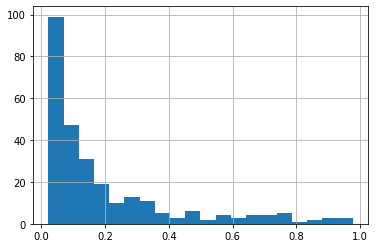

In [15]:
movies_df['Propensity_score'].hist(bins=20)

In [16]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

Based on the propensity score we calculate similarity between the two gropus and make a bipartite graph. The edge weight between two nodes are the similarity scores. We want to find a maximal weight matching between the two groups (**highly_quoted** and **lowly_quoted**). The matching is found using the Hungarian algorithm, the graph is stored in a **networkx** object.

In [17]:
# Separate the treatment and control groups
highly_quoted_df = movies_df[movies_df['highly_quoted'] == 1]
lowly_quoted_df = movies_df[movies_df['highly_quoted'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for l_id, l_row in lowly_quoted_df.iterrows():
    for h_id, h_row in highly_quoted_df.iterrows():

        similarity = get_similarity(l_row['Propensity_score'],h_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(l_id, h_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

# Make a 'mask' of the indexes of the matched movies
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

Now we have a matching, it's time to check the means and the distributions of our filtered data.

In [18]:
balanced_df = movies_df.loc[matched]
balanced_highly_quoted_df = balanced_df[balanced_df['highly_quoted'] == 1]
balanced_lowly_quoted_df = balanced_df[balanced_df['highly_quoted'] == 0]

We check the propensity scores, now it seems more balanced compared to the previous plot.

<AxesSubplot:>

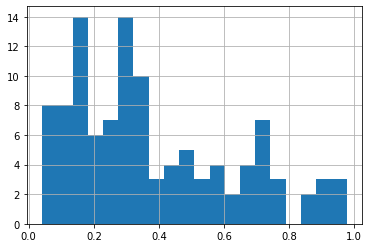

In [19]:
balanced_df['Propensity_score'].hist(bins=20)

In [20]:
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

In [21]:
high_CI = bootstrap_CI(balanced_highly_quoted_df['usa_gross_income'], 1000)
low_CI = bootstrap_CI(balanced_lowly_quoted_df['usa_gross_income'], 1000)
high_mean = balanced_highly_quoted_df['usa_gross_income'].mean()
low_mean = balanced_lowly_quoted_df['usa_gross_income'].mean()

print(f'mean usa gross income on highly quotes moves: {high_mean},    95%-CI: {high_CI} ')
print(f'mean usa gross income on lowly quotes moves: {low_mean},     95%-CI:  {low_CI}')

mean usa gross income on highly quotes moves: 288705109.74545455,    95%-CI: [237569284.96318182, 350144012.3122727] 
mean usa gross income on lowly quotes moves: 206249748.6,     95%-CI:  [175591263.6472727, 242392163.01999998]


In [22]:
stats.ttest_ind(balanced_highly_quoted_df['usa_gross_income'], balanced_lowly_quoted_df['usa_gross_income'], equal_var=False)

Ttest_indResult(statistic=2.492717014276856, pvalue=0.014444836319132393)

More quoted movies have higher mean gross income, the t-test and the confidence intervals point out they do differ significantly, we conclude that quotes have a significant positive effect on the gross income.

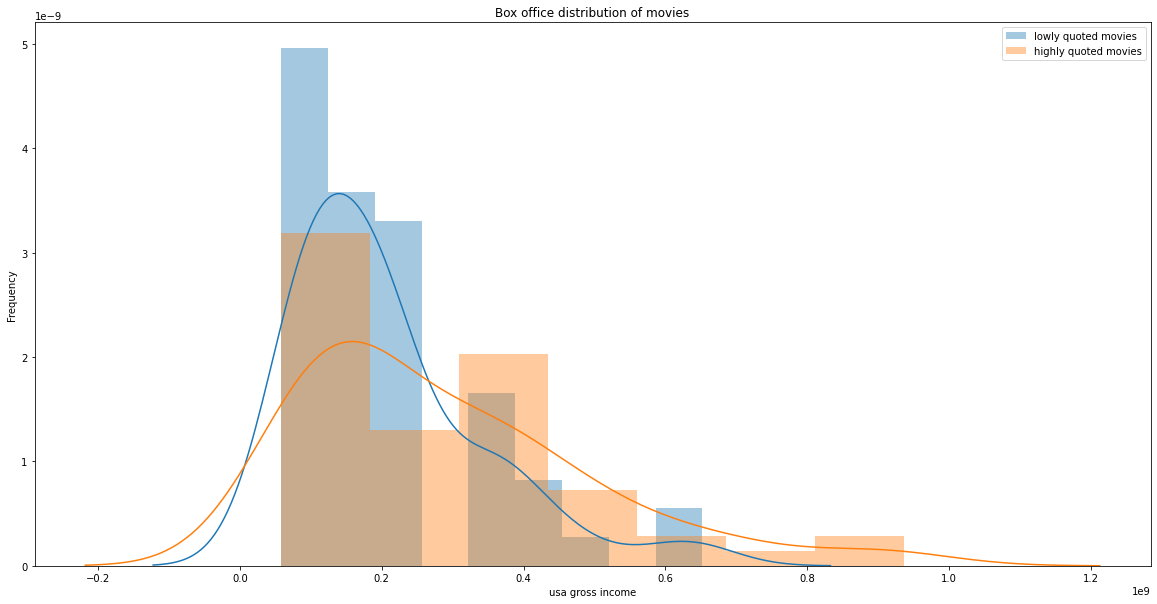

In [23]:
fig, ax = plt.subplots(figsize =(20,10))
sns.distplot(balanced_lowly_quoted_df['usa_gross_income'], hist=True, label='lowly quoted movies', ax=ax)
sns.distplot(balanced_highly_quoted_df['usa_gross_income'], hist=True, label='highly quoted movies', ax=ax)
ax.set(title='Box office distribution of movies',xlabel='usa gross income', ylabel='Frequency')
plt.legend()
plt.show()

---

# RQ2 <a class="anchor" id="chapter3"></a>

---

# RQ3: An Investigation into Time Series Box Office and Quotes in a Few Movies <a class="anchor" id="chapter3"></a>

## Proposed method: 
## 3.1. Initial analysis and Kolmogorov-Smirnov test <a class="anchor" id="chapter31"></a>

In this section, we will investigate the relationship between the boxOffice dataset and the Quotes in X movies.

In [24]:
#Load in the boxOffice dataset
filename = f"boxOffice"
data_dir = os.getcwd() + os.sep + 'exploratory' + os.sep + 'data'

df_boxOffice = pd.read_pickle(rf"{data_dir}{os.sep}{filename}.pkl")

quotes = pd.read_pickle('./exploratory/data/Quotebank_sentiment.pkl')
quotes['date'] = pd.to_datetime(quotes['date'])

To figure out which movies to use, we found that movies with few quotes were too boring. Below there is an example with Dolittle

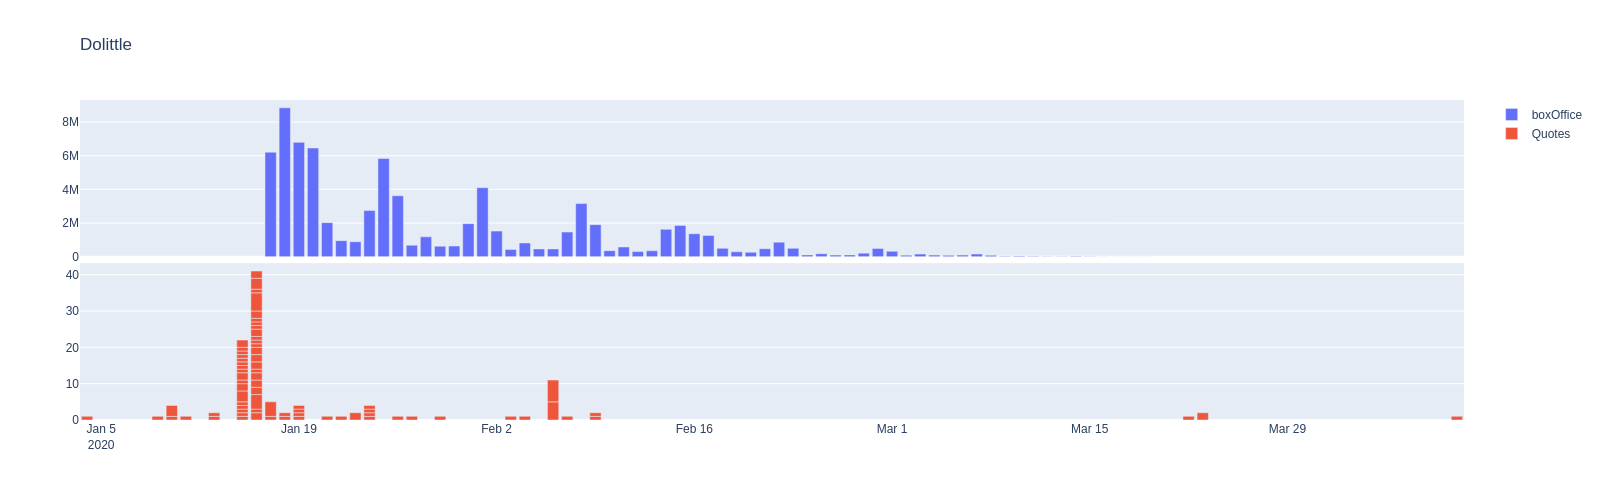

In [38]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.02)

fig.append_trace(go.Bar(x=df_boxOffice[df_boxOffice.movie=='Dolittle'].days, y = df_boxOffice[df_boxOffice.movie=='Dolittle'].daily, name='boxOffice'), row=1, col=1)
fig.append_trace(go.Bar(x=quotes[quotes.movie=='Dolittle'].date, y = quotes[quotes.movie=='Dolittle'].numOccurrences, name = 'Quotes'), row=2, col=1)
fig.update_layout(title_text="Dolittle")
fig.update_layout(width=1600, height=500)
fig.show('png')

Instead we decided to take the three most quoted movies. The cell below shows how we sorted the movies:

In [39]:
movies, freq_unsorted = np.unique(quotes.movie, return_counts=True)
freq, movies = np.array(list(zip(*sorted(zip(freq_unsorted, movies), reverse=True))))

print("Three top quoted movies: ")
list(zip(movies, freq))[:3]

Three top quoted movies: 


[('Star Wars: Episode VIII - The Last Jedi', '8368'),
 ('Star Wars: Episode VII - The Force Awakens', '7812'),
 ('Thor: Ragnarok', '6849')]

There you have it. We will do similar plots to the one above with Dolittle, however, we will only plot the period in which the movies were in theaters. This will come in handy when we test the distributions. The cells below will filter the data and plot it:

In [40]:
#Get the min and max day for all three films
min_day_sw_VIII = list(df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VIII - The Last Jedi'].days)[0]
max_day_sw_VIII = list(df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VIII - The Last Jedi'].days)[-1]

min_day_sw_VII = list(df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VII - The Force Awakens'].days)[0]
max_day_sw_VII = list(df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VII - The Force Awakens'].days)[-1]

min_day_thor = list(df_boxOffice[df_boxOffice.movie=='Thor: Ragnarok'].days)[0]
max_day_thor = list(df_boxOffice[df_boxOffice.movie=='Thor: Ragnarok'].days)[-1]

#Define new dataframes, where we can drop all quotes outside of our scope
sw_VIII = quotes[quotes.movie=='Star Wars: Episode VIII - The Last Jedi']
sw_VII = quotes[quotes.movie=='Star Wars: Episode VII - The Force Awakens']
thor = quotes[quotes.movie=='Thor: Ragnarok']

#Drop all quotes outside of our time periods:
sw_VIII=sw_VIII[sw_VIII.date>=min_day_sw_VIII]
sw_VIII=sw_VIII[sw_VIII.date<=max_day_sw_VIII]

sw_VII=sw_VII[sw_VII.date>=min_day_sw_VII]
sw_VII=sw_VII[sw_VII.date<=max_day_sw_VII]

thor=thor[thor.date>=min_day_thor]
thor=thor[thor.date<=max_day_thor]

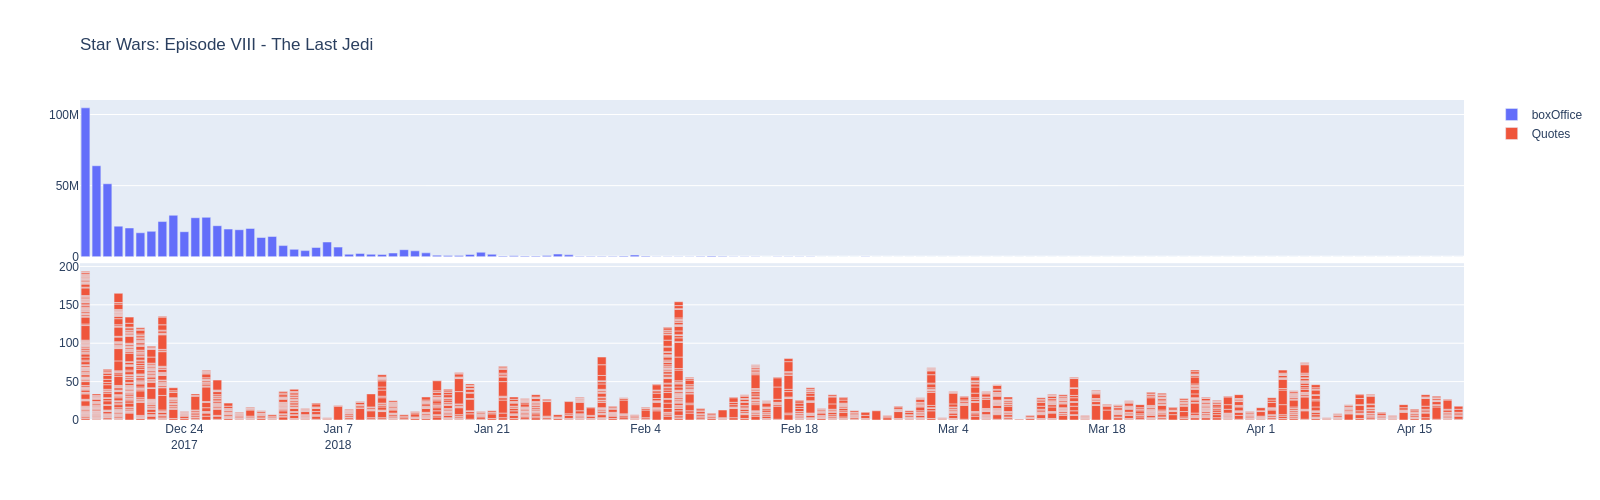

In [41]:
#Star Wars: Episode VIII - The Last Jedi:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.02)

fig.append_trace(go.Bar(x=df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VIII - The Last Jedi'].days, y = df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VIII - The Last Jedi'].daily, name='boxOffice'), row=1, col=1)
fig.append_trace(go.Bar(x=sw_VIII.date, y = sw_VIII.numOccurrences, name = 'Quotes'), row=2, col=1)
fig.update_layout(title_text="Star Wars: Episode VIII - The Last Jedi")
fig.update_layout(width=1600, height=500)
fig.show('png')

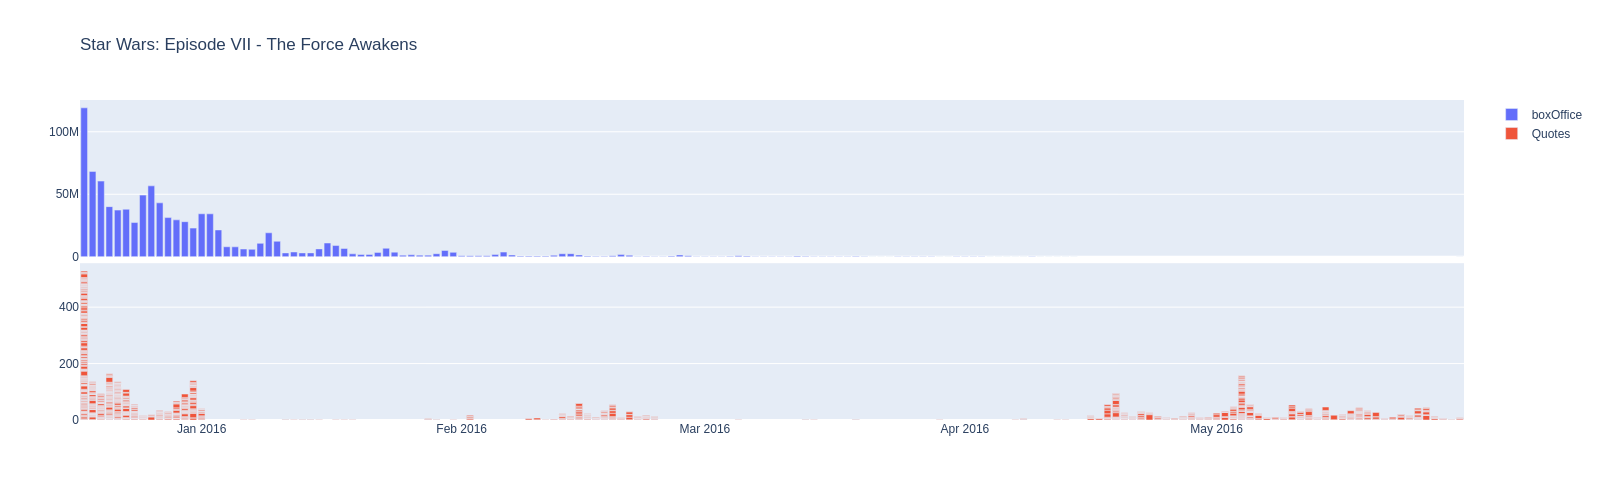

In [42]:
#Star Wars: Episode VII - The Force Awakens
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.02)

fig.append_trace(go.Bar(x=df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VII - The Force Awakens'].days, y = df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VII - The Force Awakens'].daily, name='boxOffice'), row=1, col=1)
fig.append_trace(go.Bar(x=sw_VII.date, y = sw_VII.numOccurrences, name = 'Quotes'), row=2, col=1)
fig.update_layout(title_text="Star Wars: Episode VII - The Force Awakens")
fig.update_layout(width=1600, height=500)
fig.update_layout( width=1600, height=500)
fig.show('png')

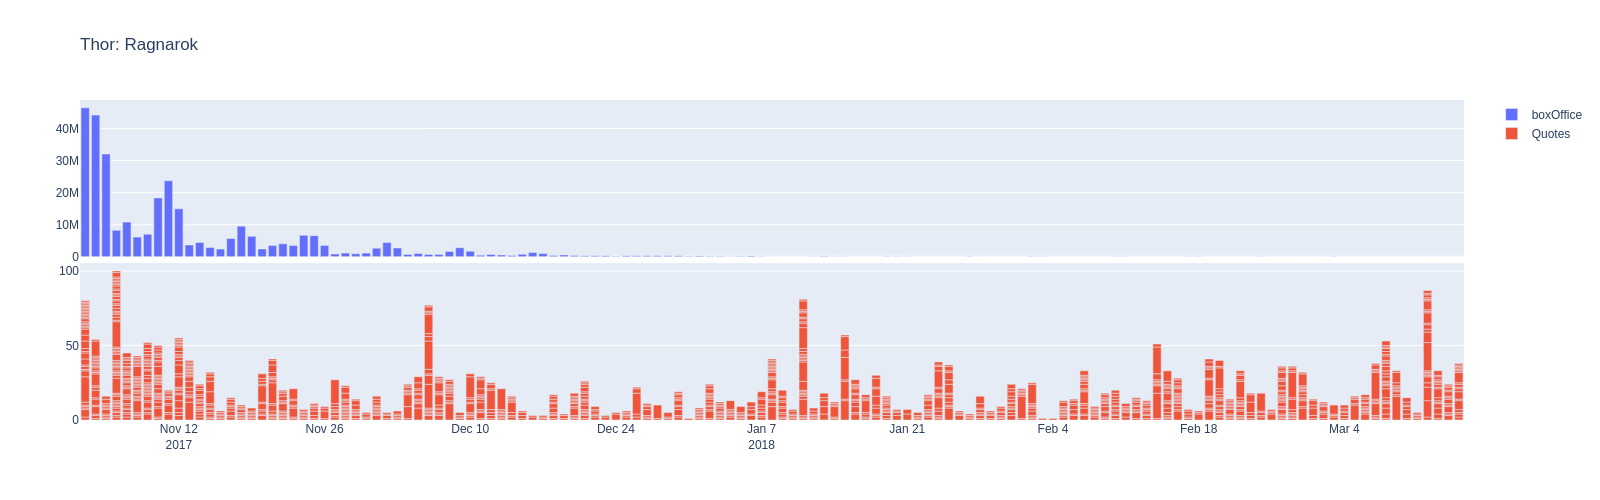

In [43]:
#Thor: Ragnarok
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.02)

fig.append_trace(go.Bar(x=df_boxOffice[df_boxOffice.movie=='Thor: Ragnarok'].days, y = df_boxOffice[df_boxOffice.movie=='Thor: Ragnarok'].daily, name='boxOffice'), row=1, col=1)
fig.append_trace(go.Bar(x=thor.date, y = thor.numOccurrences, name = 'Quotes'), row=2, col=1)
fig.update_layout(title_text="Thor: Ragnarok")
fig.update_layout( width=1600, height=500)
fig.show('png')

It does not look like there is a relationship between the boxOffice and quotes, but let's test it! We start by scaling everything into the range [0,1]. This is done in the next cell:

In [44]:
sw_VIII_box = df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VII - The Force Awakens'].daily
sw_VII_box = df_boxOffice[df_boxOffice.movie=='Star Wars: Episode VIII - The Last Jedi'].daily
thor_box = sw_VIII_box = df_boxOffice[df_boxOffice.movie=='Thor: Ragnarok'].daily

sw_VIII_box = list((sw_VIII_box - sw_VIII_box.min()) / (sw_VIII_box.max() - sw_VIII_box.min()))
sw_VII_box = list((sw_VII_box - sw_VII_box.min()) / (sw_VII_box.max() - sw_VII_box.min()))
thor_box = list((thor_box - thor_box.min()) / (thor_box.max() - thor_box.min()))

sw_VIII = sw_VIII.groupby('date').numOccurrences.sum()
sw_VII = sw_VII.groupby('date').numOccurrences.sum()
thor = thor.groupby('date').numOccurrences.sum()

sw_VIII_quotes = list((sw_VIII - sw_VIII.min()) / (sw_VIII.max() - sw_VIII.min()))
sw_VII_quotes = list((sw_VII - sw_VII.min()) / (sw_VII.max() - sw_VII.min()))
thor_quotes = list((thor - thor.min()) / (thor.max() - thor.min()))

Now we can do some testing. We chose to use the Kolmogorov-Smirnov test (kstest). All parameters are set to default as it works well in our case:

In [45]:
sw_VII_stat, sw_VII_p = kstest(sw_VII_box,sw_VII_quotes)
print('Star Wars: Episode VII - The Force Awakens:\nks-stat: ',sw_VII_stat,'\np-value: ', sw_VII_p,'\n')

sw_VIII_stat, sw_VIII_p = kstest(sw_VIII_box,sw_VIII_quotes)
print('Star Wars: Episode VIII - The Last Jedi:\nks-stat: ',sw_VIII_stat,'\np-value: ', sw_VIII_p,'\n')

thor_stat, thor_p = kstest(thor_box,thor_quotes)
print('Thor: Ragnarok:\nks-stat: ',thor_stat,'\np-value: ', thor_p)

Star Wars: Episode VII - The Force Awakens:
ks-stat:  0.41774891774891776 
p-value:  3.341567245129795e-09 

Star Wars: Episode VIII - The Last Jedi:
ks-stat:  0.7351712614870509 
p-value:  8.881784197001252e-16 

Thor: Ragnarok:
ks-stat:  0.7293233082706767 
p-value:  1.5328238282581075e-34


We will reject all the null-hypothesises (that the distributions for quotes and boxOffice was identical) because of the low p-values (lower than .05, the default alpha). Therefore, we cannot say that the number of quotes about one of the three movies on a given day can influence (or be influenced by) the boxOffice of said movie on that given day.

---

## Proposed method: 
## 3.2. Checking correlation between distribution of quotes over time and box office time series data <a class="anchor" id="chapter32"></a>

We are interested in whetehr the time series of quotes and time series of box office relate to each other in some sense. Firts, ee will transform the time series to become stationary. Then we propose two models:
- We fit a VAR (Vector autoregression) model on the data and check the correlation of the residuals.
- We perform a Granger Causality test 

For this question we only consider one choses movie, our choice is Avengers: Infinity War.

Analyisis based on this blog post https://towardsdatascience.com/a-quick-introduction-on-granger-causality-testing-for-time-series-analysis-7113dc9420d2.

In [46]:
movie_title = "Avengers: Infinity War"
movie_title = movie_title.replace(" ", "_")
movie_title = movie_title.replace("-", "_")
movie_title = movie_title.replace(":", "")
movie_title

'Avengers_Infinity_War'

In [47]:
title = "Avengers: Infinity War"
time_series = quotes[quotes['movie'] == title].groupby(['date'],  as_index=False).count()[['date', 'quotation']]

In [48]:
bo = pd.read_csv('./exploratory/data/time_series_box_office_data/Avengers_Infinity_War___Box_Office_Mojo.csv')
bo = bo.rename(columns={'days': 'date'})
bo['date'] = pd.to_datetime(bo['date'])
bo = bo[['date','daily']]
time_series = time_series.merge(bo, how='left', on='date')
time_series = time_series.dropna()

<AxesSubplot:xlabel='date', ylabel='daily'>

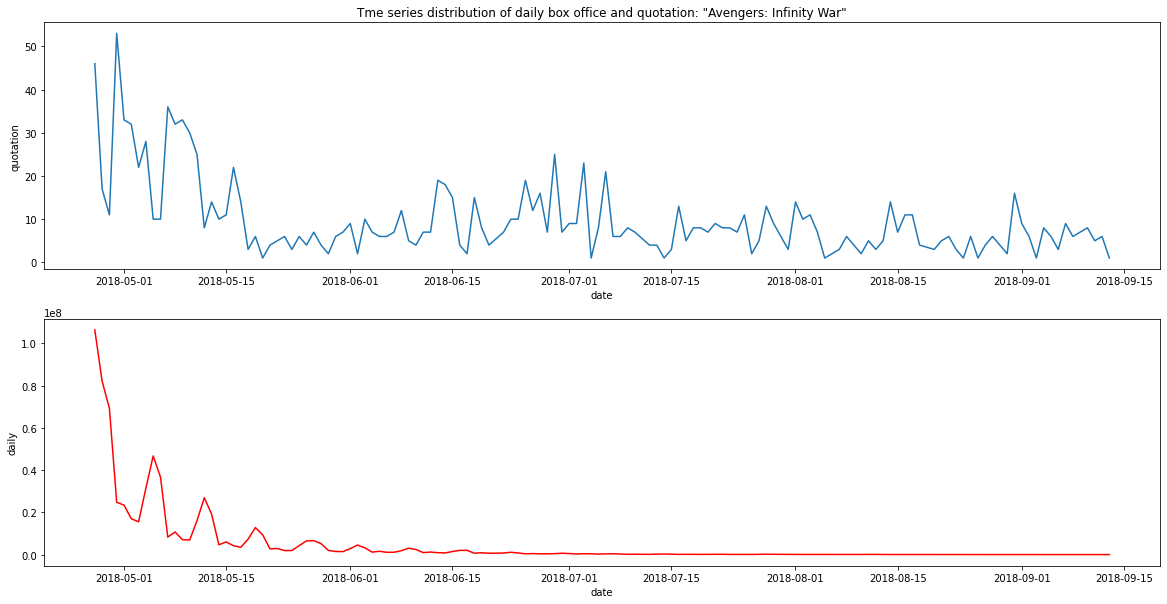

In [49]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20,10))
ax[0].set(title='Tme series distribution of daily box office and quotation: "Avengers: Infinity War"')
sns.lineplot(x='date', y='quotation', data=time_series, ax=ax[0])
sns.lineplot(x='date', y='daily', data=time_series, ax=ax[1], color='red')

We use an ADF test to determine whether the underlying time series are stationary or not. Null hypothesis: it suggests the time series is not stationarity (if failed to be rejected)

In [50]:
result = adfuller(time_series['quotation'].values)
print(f'ADF Statistics for quotation: {result[0]}')
print(f'p-value: {result[1]}')

result = adfuller(time_series['daily'].values)
print(f'ADF Statistics for box office: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistics for quotation: -4.055861258289217
p-value: 0.001144657257171167
ADF Statistics for box office: -4.981642171850192
p-value: 2.4126634872146793e-05


Small p values suggest that the time series are stationary. We will note that this is likely because of the long tails of the two time series, at the premier of the movie there is clearly a peak at both cases. We will try to get rid of this minor issue and transform our time series with the difference method. It can be used to remove the series dependence on time, so-called temporal dependence.

<AxesSubplot:xlabel='date', ylabel='diff_daily'>

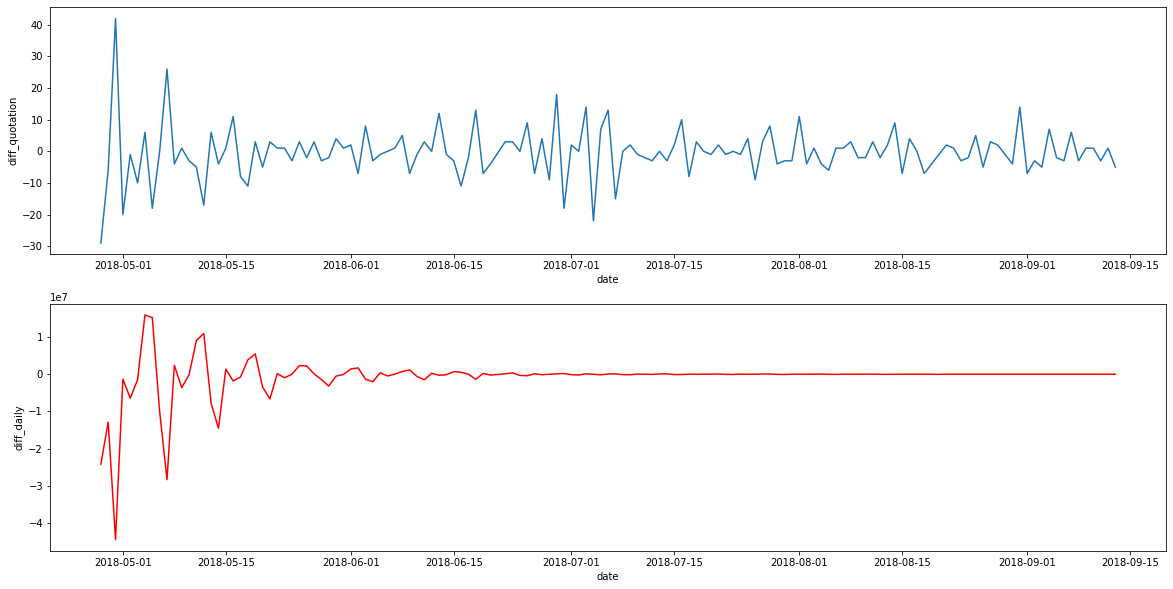

In [51]:
time_series['diff_quotation'] = time_series['quotation'].diff()
time_series['diff_daily'] = time_series['daily'].diff()

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20,10))
sns.lineplot(x='date', y='diff_quotation', data=time_series, ax=ax[0])
sns.lineplot(x='date', y='diff_daily', data=time_series, ax=ax[1], color='red')


We will do the ADF tests just to be sure.

In [52]:
time_series = time_series.dropna()
result = adfuller(time_series['diff_quotation'].values)
print(f'ADF Statistics for quotation: {result[0]}')
print(f'p-value: {result[1]}')

result = adfuller(time_series['diff_daily'].values)
print(f'ADF Statistics for box office: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistics for quotation: -9.37547729509302
p-value: 7.186865372345419e-16
ADF Statistics for box office: -3.547067774241008
p-value: 0.006857445486581326


The plots and the p-values suggest that we eliminated the time dependency. We will move on to check correlations.

We will use the VAR model fist (Vector autoregression). The VAR class assumes that the passed time series are stationary.

A VAR model describes the evolution of a set of $k$ variables, over time. The variables are collected in a vector, $y_t$, which is of length $k$. The vector is modelled as a linear function of its previous value. The last term is the error term. $$y_t = A_1 y_{t-1} + A_2 y_{t-2} +... A_{p} y_{t-p} + \epsilon$$

We will try models with different lags, The best model will be selected by the minimum AIC score. If we have a model with $k$ parameters, and $L$ is the maximum value of the likelihood function for the model then the AIC score is given by: $AIC = 2k - 2 log(L)$

In [53]:
#time_series = time_series.set_index('date')
def best_lag_by_aic(data):
    model = VAR(data)
    AIC = []
    for i in range(0,15):
        result = model.fit(i)
        AIC.append(result.aic)
    return np.argmin(AIC)

best = best_lag_by_aic(time_series[['diff_daily', 'diff_quotation']])
print(f' Best model: {best}')

 Best model: 11


In [54]:
model = VAR(time_series[['diff_daily', 'diff_quotation']])
results = model.fit(maxlags=11, ic='aic')
results.resid_corr

array([[ 1.        , -0.05743393],
       [-0.05743393,  1.        ]])

The residual errors of the VAR model suggests that the the two time series are not correlated.

## Granger Causality 

Now we perform a Granger Causality Test. The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another. We say that a variable $X$ that evolves over time Granger-causes another evolving variable $Y$ if predictions of the value of $Y$ based on its own past values and on the past values of $X$ are better than predictions of $Y$ based only on $Y$'s own past values.

Formally let $\mathcal{F}(t)$ be the filtration w.r.t. $X$ and $Y$ and let $\mathcal{G}(t)$ be the sub-filtration w.r.t. only $Y$. ($\mathcal{F}(t)$ has more information than $\mathcal{G}(t)$). We want to test the hypothesis that $\mathcal{P}(Y(t+1)\in A| \mathcal{F}(t)) \neq \mathcal{P}(X(t+1)\in A | \mathcal{G}(t))$ for arbitrary measurable set $A$.

In practise we undertake the following steps:
- fit a VAR model to $Y$, that is $y_t=\sum a_i y_{t-i} + \epsilon$
- fit a second VAR model to $Y$ using the information from $X$ as well $y_t =\sum a_i y_{t-i} + \epsilon + \sum b_j x_{t-j} $
- Test the null hypothesis that the coefficients corresponding to past values of the second time series are zero. (We will use chi2 test to do so, another popular option is to use a series of t and F tests)
- We reject the the null hypothesis if there exists a significant predictor, in this case we say that $X$ Granger causes $Y$.

In [55]:
maxlag=11
test = 'ssr_chi2test'
def grangers_causation(data, test='ssr_chi2test', maxlag=maxlag):    
    test_result = grangercausalitytests(data, maxlag=maxlag, verbose=False)
    p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
    min_p_value = np.min(p_values)
    #params = test_result[np.argmin(p_values) + 1][1][1].params
    return min_p_value

test_result = grangers_causation(time_series[['diff_daily', 'diff_quotation']], test=test, maxlag=maxlag)
test_result

0.0

We can reject the null hypothesis and conclude that diff_daily_x Granger causes diff_quotation_y. On the other hand diff_daily_y Granger causes diff_quotation_x. All the time series in the above data are interchangeably Granger causing each other.

Now let's make a helper function from the above steps and do the analysis for all the movies we have.

In [56]:
df_boxOffice = pd.read_pickle(rf"{data_dir}{os.sep}boxOffice.pkl")   

In [57]:
def time_series_granger_pipeline(titles):
    cause_box = {}
    for i, title in enumerate(titles):
        try:
            #load quotations
            time_series = quotes[quotes['movie'] == title].groupby(['date'],  as_index=False).count()[['date', 'quotation']]

            #load box office
            bo = df_boxOffice[df_boxOffice['movie']==title]
            bo = bo.rename(columns={'days': 'date'})
            bo['date'] = pd.to_datetime(bo['date'])
            bo = bo[['date','daily']]
            time_series = time_series.merge(bo, how='left', on='date')
            time_series = time_series.dropna()

            #transforming into stationary time series
            time_series['diff_quotation'] = time_series['quotation'].diff() 
            time_series['diff_daily'] = time_series['daily'].diff()
            time_series = time_series.dropna()
            
            #choosing the best lag for Vector Autoregression by AIC score
            maxlag = best_lag_by_aic(time_series[['diff_daily', 'diff_quotation']])
            
            gcm = grangers_causation(time_series[['diff_daily', 'diff_quotation']], test='ssr_chi2test', maxlag=maxlag)
            cause_box[title] = (gcm, gcm < 0.05)
        except:
            pass
       
    return cause_box

In [58]:
titles = list(quotes['movie'].unique())
cause_box = time_series_granger_pipeline(titles)

Finally we plot the results. We are interested in whether the daily number of quotes Granger causes the box office sales.

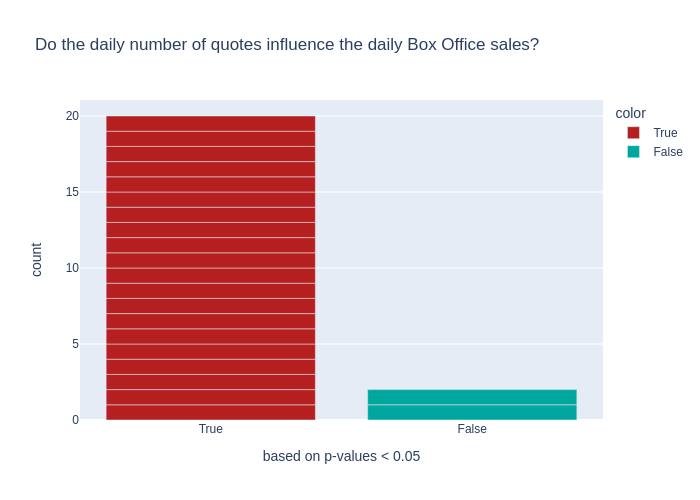

In [60]:
import plotly.express as px

sent2box = np.array([(movie, p_val, reject) for movie, (p_val, reject) in cause_box.items()])
temp = pd.DataFrame(sent2box).rename(columns={0: 'movie', 1: 'p_vals', 2: 'reject'})

fig = px.bar(x=temp.reject, y=(np.ones(len(temp.reject))), labels={'x':'based on p-values < 0.05', 'y':'count'},
            hover_name =temp.movie,
            color=temp.reject,
            color_discrete_sequence=['#B51F1F', '#00A79F'],
            title='Do the daily number of quotes influence the daily Box Office sales?')
fig.update_layout(width=700, height=500)
fig.show('png')

We will adjust the p-values with the Bonferroni method.

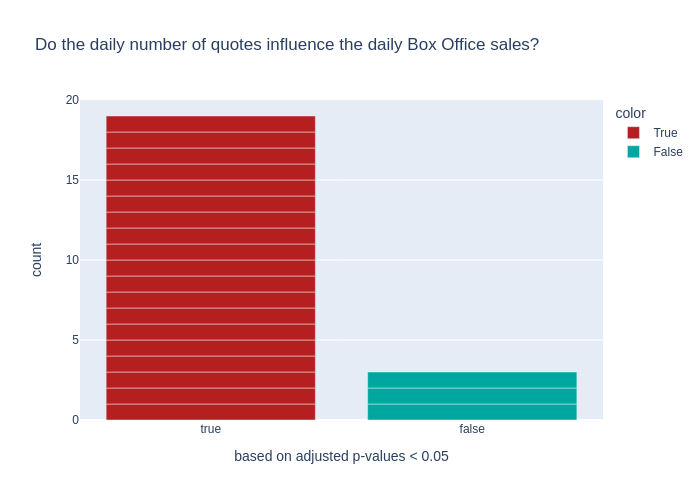

In [61]:
reject_sent2box, adj_pvals_sent2box, _, _ = multipletests(sent2box[:,1].astype(float), alpha=0.05, method='bonferroni')
adj_pvals_df = pd.DataFrame(adj_pvals_sent2box, reject_sent2box)
adj_pvals_df['movie'] = sent2box[:,0]
adj_pvals_df = adj_pvals_df.reset_index().rename(columns={0: 'p_vals', 'index': 'reject'})

fig = px.bar(x=adj_pvals_df.reject, y=(np.ones(len(adj_pvals_df.reject))), labels={'x':'based on adjusted p-values < 0.05', 'y':'count'},
            hover_name =adj_pvals_df.movie,
            color=adj_pvals_df.reject, #sent2box[:,0],
            color_discrete_sequence=['#B51F1F', '#00A79F'],
            title='Do the daily number of quotes influence the daily Box Office sales?')
fig.update_layout(width=700, height=500)
fig.show('png')

Conclusion: it seems that for most of the movies we can conclude Granger causality, which means in general big media coverage results with high box office revenue.

---

# RQ5: The effect of COVID on media coverage of movies <a class="anchor" id="chapter5"></a>

## Proposed method: 
## 5.1. Calculate mean number of quotes on movies between 2015-2019 on a daily basis, calculate confidence intervals (bootstrapping), compare with 2020 data <a class="anchor" id="chapter51"></a>

In [62]:
with open('./exploratory/data/rq1/top_10.json') as json_file:
    top10_movies = json.load(json_file)

In [63]:
def count_quotes_by_movies(quotes, top10_movies):

    pre_covid_movies = top10_movies[str(2015)] + top10_movies[str(2016)] + top10_movies[str(2017)] + top10_movies[str(2018)] + top10_movies[str(2019)]

    covid_movies = top10_movies[str(2020)]

    all_quotes_by_date = []
    for movie in pre_covid_movies:
        df = quotes[quotes['movie'] == movie]['date']
        df = dict(Counter(df))
        all_quotes_by_date.append({f'{k.month}-{k.day}': v for k, v in df.items()})

    final = defaultdict(list)
    for dict_ in all_quotes_by_date:
        for k, v in dict_.items():
            final[k].append(v)

    covid_quotes_by_date = []
    for movie in covid_movies:
        df = quotes[quotes['movie'] == movie]['date']
        df = dict(Counter(df))
        covid_quotes_by_date.append({f'{k.month}-{k.day}': v for k, v in df.items()})

    covid_final = defaultdict(list)
    for dict_ in covid_quotes_by_date:
        for k, v in dict_.items():
            covid_final[k].append(v)

    return final, covid_final

def calculate_average_by_date(final, covid_final):
    final = OrderedDict(sorted(final.items(), key=lambda t: t[0]))
    covid_final = OrderedDict(sorted(covid_final.items(), key=lambda t: t[0]))
    averages = OrderedDict()
    covid_averages = OrderedDict()

    for k,v in final.items():
        averages[k] = np.array(v).mean()
        covid_averages[k] = 0
    
    for k,v in covid_final.items():
        covid_averages[k] = np.array(v).mean()

    return averages, covid_averages

In [64]:
final, covid_final = count_quotes_by_movies(quotes, top10_movies)
final = OrderedDict(sorted(final.items(), key=lambda t: t[0]))
covid_final = OrderedDict(sorted(covid_final.items(), key=lambda t: t[0]))
averages, covid_averages = calculate_average_by_date(final, covid_final)

2020 is a leap year, so we get rid of 29 of February

In [65]:
leap = covid_averages['2-29']
print(f'number of quotes on February 29: {leap}')
del covid_averages['2-29']

number of quotes on February 29: 3.0


In [66]:
#bootsrap confidence intervals
lens = []
for k,v in tqdm(final.items()):
    lens.append(len(v))
avg = sum(lens)/len(lens)
print(f'average number of movies being quoted: {avg}')

lower_bound = []
upper_bound = []
for k,v in tqdm(final.items()):
    if len(v) < int(avg):
        x = np.zeros(int(avg)) #padding with zeros if we have few observations
        x[:len(v)] = v
    l, u = bootstrap_CI(x, 1000)
    lower_bound.append(l)
    upper_bound.append(u)

100%|██████████| 366/366 [00:00<00:00, 694308.12it/s]


average number of movies being quoted: 25.415300546448087


100%|██████████| 366/366 [00:23<00:00, 15.90it/s]


Text(0, 0.5, 'average number of quotes')

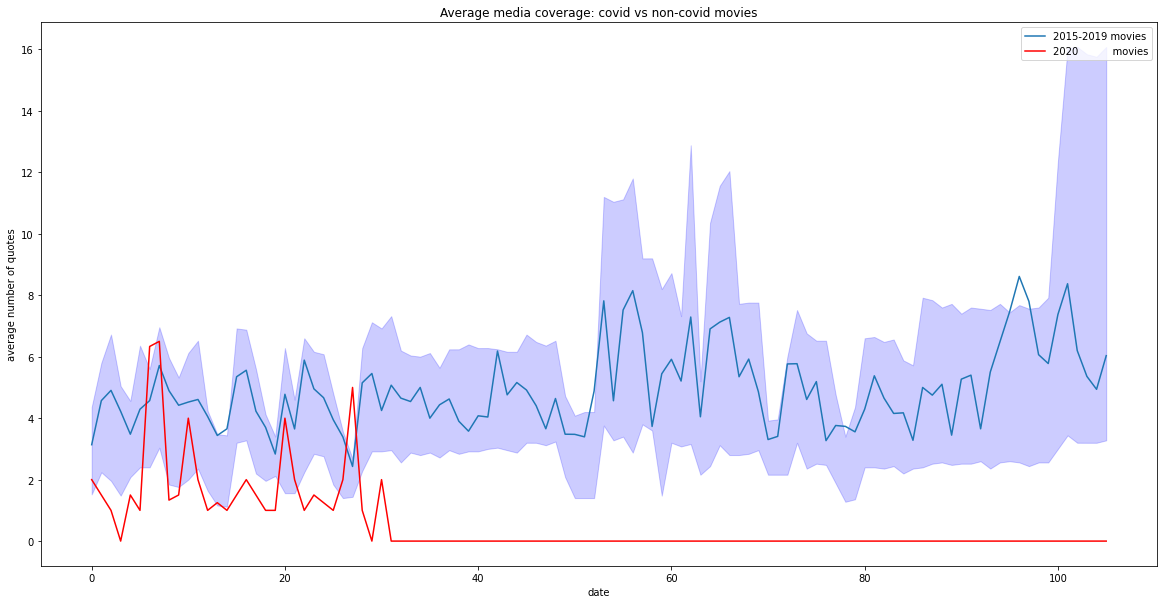

In [67]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_title('Average media coverage: covid vs non-covid movies')
plt.fill_between(np.arange(106), lower_bound[:106], upper_bound[:106], alpha=.2, color='blue')
sns.lineplot(np.arange(106), list(averages.values())[:106], ax=ax, label='2015-2019 movies')
sns.lineplot(np.arange(106), list(covid_averages.values())[:106], ax=ax, color='red', label='2020           movies')
ax.set_xlabel('date')
ax.set_ylabel('average number of quotes')

The plot suggests that from the beginning of march in 2020, movies were quoted less than in the years before. The red line is not in the confidence interval, so we can conclude the difference is significant. This means the covid pendemic had a negative effect on the news about movies.

---

## Proposed method:
## Use regression for comparison of the mean number of quotes across movies in covid and non-covid period, use t-test for comparison of means <a class="anchor" id="chapter52"></a>

We have to be extra careful in this task again, 2020 data is until 04-16, so in ored to make it comperable we will only consider quotes in this period between 2015-2019.

In [68]:
filtered = []

quotes['date'] = pd.to_datetime(quotes['date'])

#filtering quotes before 2020 to get quotes only before 04-16 (we only have data for this period in 2020)
for year in range(2015, 2020):
    value_to_check = pd.Timestamp(year, 4, 16)
    filter_mask = quotes['date'] < value_to_check
    filtered.append(quotes[filter_mask])

#filteirng quotes in 2020
value_to_check = pd.Timestamp(2019, 12, 31)  
filter_mask = quotes['date'] > value_to_check
filtered.append(quotes[filter_mask])
quotes_before_04_16 = pd.concat(filtered)

covid = df.merge(quotes_before_04_16.groupby('movie').sum()['numOccurrences'],left_on='original_title', right_index=True) #merge quotes with movies
covid = covid[['original_title','year', 'numOccurrences']]
covid['year'] = covid['year'].astype(int)
covid = covid[covid['year']>2014]
covid['covid'] = 0
covid.loc[covid['year'] == 2020, 'covid'] = 1 #adding dummy variable whether a movie came out in 2020 or not (effected by the pandemic)

<AxesSubplot:xlabel='covid', ylabel='numOccurrences'>

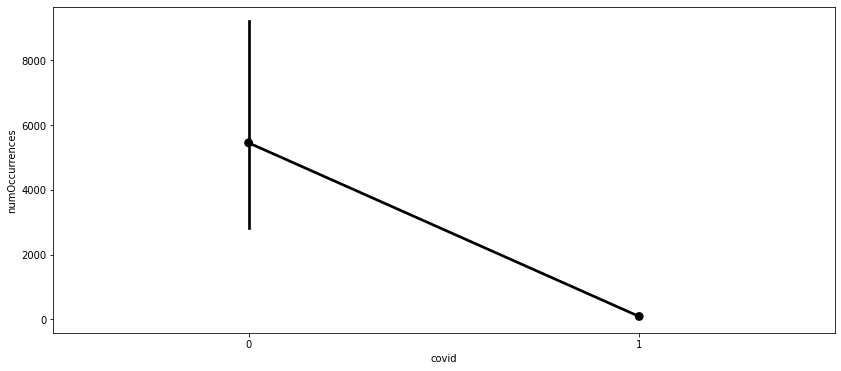

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(14,6))
sns.pointplot(x='covid', y='numOccurrences', data=covid, color='black', ax=ax)

The plot suggests that the difference is significant, the two dot represent the mean of the data and the lines are the bootstrapped confidence intervals, since the intervals do not overlap, the difference is significant. We can come to similar conclusion using linear regression

In [70]:
res = smf.ols(formula='numOccurrences ~ covid', data=covid).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         numOccurrences   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.593
Date:                Tue, 14 Dec 2021   Prob (F-statistic):              0.212
Time:                        21:36:14   Log-Likelihood:                -618.51
No. Observations:                  58   AIC:                             1241.
Df Residuals:                      56   BIC:                             1245.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5450.5294   1475.402      3.694      0.0

We can observe the following:
$$ \text{number of quotes} = 5450 - 5360 \times \text{covid}$$

From the regression we can see immediately see that the mean score for non-covid movies is the intercept ($2264 $), and adding the dummy indicator *covid*, we get the mean score for movies in 2020, which is $66$.